# Recurrent network and dynamics activity
In this activity you will train a LSTM network to approximate a certain nonlinear dynamic system. The system is a van der Pol oscillator. It has has two state variables, which we can call $x_1$ and $x_2$. The state variables change over time in a way that depends on the state variables themselves. Specifically, 
\begin{align*}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= \mu (1-x_1^2) x_2 - x_1 
\end{align*}
where $\mu>0$ is a parameter. Trajectories of the state variables can be plotted in a flow field, like so ... 

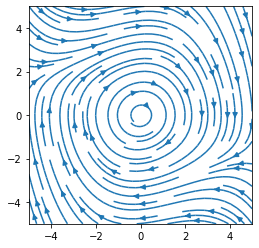

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_flow_field():
    x1 = np.linspace(-5, 5, 20)
    x2 = np.linspace(-5, 5, 20)
    X1, X2 = np.meshgrid(x1, x2)

    mu = 0.1
    dx1 = X2
    dx2 = mu * (1-X1**2) * X2 - X1

    fig = plt.figure(figsize=(4, 4))
    plt.streamplot(X1, X2, dx1, dx2, density=1)

plot_flow_field()
plt.show()

This system is a kind of limit-cycle oscillator. It is an oscillator because the state-variable trajectories go around in loops. It is a limit-cycle oscillator because all of its trajectories (starting from any state) converge to the same loop (called the limit cycle). Trajectories starting near the centre gradually spiral out while those starting farther out gradually spiral in until they all end up on the same cycle. 

To simulate a single trajectory of the system from a given starting state, we can use a standard differential equation solver from Scipy. To do this, we have to implement the right-hand side of the dynamic equations as a Python function. Let's do that and plot a state trajectory two seconds long starting from a random state. We will overlay it on the flow field to confirm that the trajectory follows the flow field.   

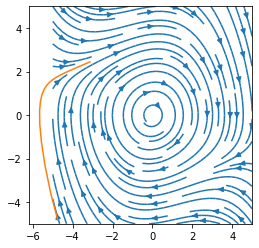

In [19]:
from scipy.integrate import solve_ivp

def van_der_pol_dynamics(t, x):
    """    
    :param t: time (not used, but the solver expects a function with this argument)  
    :param x: state vector 
    :return: state derivative vector 
    """

    mu = 0.1
    dx1 = x[1]
    dx2 = mu * (1 - x[0] ** 2) * x[1] - x[0]
    return [dx1, dx2]

x0 = -5 + 10*np.random.rand(2)
solution = solve_ivp(van_der_pol_dynamics, [0, 2], x0, max_step=.1)

plot_flow_field()
plt.plot(solution.y[0,:], solution.y[1,:])
plt.show()

We will train a LSTM neural network to approximate these dynamics. To do this we will need batches of random example trajectories. The following code will produce those. 

In [20]:
import torch

def get_random_trajectory():
    """
    :return: a van der Pol trajectory from a random initial state
    """
    dt = .1
    T = 2
    x0 = -5 + 10*np.random.rand(2)
    solution = solve_ivp(van_der_pol_dynamics, [0, T], x0, max_step=dt)

    # Here we do some extra work to make sure all trajectories have the same 
    # number of samples (solve_ivp doesn't guarantee that). 
    times = np.linspace(0, T, int(T/dt)+1)
    trajectory = np.zeros((2,len(times)))
    trajectory[0,:] = np.interp(times, solution.t, solution.y[0,:])
    trajectory[1,:] = np.interp(times, solution.t, solution.y[1,:])

    return trajectory



def get_minibatch(n):
    """
    :param n: number of examples in minibatch
    :return: minibatch of van der Pol trajectories from random initial states
    """
    inputs = []
    trajectories = []
    for i in range(n):
        trajectory = get_random_trajectory()
        x0 = trajectory[:, 0]
        input = np.zeros_like(trajectory)
        input[:,0] = x0
        inputs.append(input.T)
        trajectories.append(trajectory.T)
    inputs = np.array(inputs).swapaxes(0, 1) # axis order: [sequence, minibatch, elements]
    trajectories = np.array(trajectories).swapaxes(0, 1)
    return torch.Tensor(inputs), torch.Tensor(trajectories)


We have set this up so that the input to the network in the first step is the starting state and the target is the full trajectory. 
Now we will make an LSTM network using a torch.nn.LSTM layer for dynamics and a torch.nn.Linear layer to decode the two-dimensional state from the network's hidden variables. 

In [21]:
import torch.nn as nn


class LSTMNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, target_dim):
        super(LSTMNetwork, self).__init__()
        # TODO: complete this method
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, target_dim)

    def forward(self, input):
        # TODO: complete this method
        x, hidden = self.lstm(input)
        return self.output(x)

Now let's make one of these networks and train it to be a van der Pol oscillator. 

In [22]:
import torch.optim as optim

loss_function = nn.MSELoss()
# TODO: create a network with 20 hidden units
model = LSTMNetwork(2, 20, 2)
# TODO: create a SGD optimizer with learning rate 0.05
optimizer = optim.SGD(model.parameters(), lr=0.05)

running_loss = 0
for sample in range(2000):
    model.zero_grad()

    initial_conditions, trajectories = get_minibatch(20)

    # TODO: run the model and calculate the loss (use the variable name "loss")
    output = model(initial_conditions)
    loss = loss_function(output, trajectories)

    loss.backward()

    # calculate and periodically loss that is smoothed over time
    running_loss = 0.9 * running_loss + 0.1 * loss.item()
    if sample % 50 == 49:
        print("Batch #{}  Loss {}".format(sample + 1, running_loss))
    optimizer.step()

Batch #50  Loss 6.293894619468839
Batch #100  Loss 5.762611855022339
Batch #150  Loss 5.607113317814739
Batch #200  Loss 2.3420097685667516
Batch #250  Loss 1.2534920413306934
Batch #300  Loss 0.8336753160823862
Batch #350  Loss 0.7769279938696865
Batch #400  Loss 0.7237882620050807
Batch #450  Loss 0.6832269376685771
Batch #500  Loss 0.725966537364175
Batch #550  Loss 0.47483595047104904
Batch #600  Loss 0.6223627692584818
Batch #650  Loss 0.3997270333887592
Batch #700  Loss 0.32180463130200204
Batch #750  Loss 0.3239360410527562
Batch #800  Loss 0.24107008418974063
Batch #850  Loss 0.23968352670959264
Batch #900  Loss 0.2634254207515801
Batch #950  Loss 0.17501580027665933
Batch #1000  Loss 0.1622199606145322
Batch #1050  Loss 0.12326706487953226
Batch #1100  Loss 0.16297130347313601
Batch #1150  Loss 0.08770518288381517
Batch #1200  Loss 0.23472384380643646
Batch #1250  Loss 0.12090761013248283
Batch #1300  Loss 0.13117692250635274
Batch #1350  Loss 0.06994494357523305
Batch #1400  

Finally we sould see how well the network does at pretending to be a van der Pol oscillator. Plot the flow field again along with trajectories from one minibatch. 

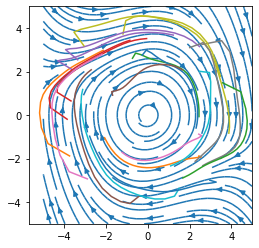

In [23]:
plot_flow_field()

initial_conditions, trajectories = get_minibatch(20)
output = model(initial_conditions).detach().numpy()
for i in range(output.shape[1]):
    trajectory = output[:,i,:]
    plt.plot(trajectory[:,0], trajectory[:,1])
plt.show()


The network struggles at the beginning of a trajectory. This will improve if you train the network for longer. 